# Basic Neural Network

A simple feedforward neural network to classify spin configurations. Based off of course material from CSCI 1051 by Teal Witter.

In [1]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

Load the data generated by the ON_Model

In [2]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])


# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"../data/binary_class/{x}", dset_transform)
         for x in ['train', 'test']}

# dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16,
#                                               shuffle=(x == "train"))
#                for x in ['train', 'test']}

trainingdata = dsets['train']
testdata = dsets['test']

#load a dataset to test for performance vs temperature
perfdata = datasets.ImageFolder(f"../data/temp_class/test", dset_transform)


trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)
perfDataLoader = torch.utils.data.DataLoader(perfdata,batch_size=64,shuffle=False)

In [3]:
print(len(trainingdata))
print(trainingdata.classes)

4100
['greater_than_critical', 'less_than_critical']


torch.Size([1, 25, 25])
0


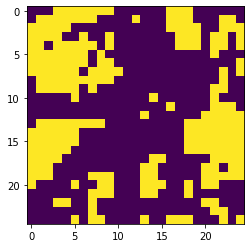

In [4]:
image, label = trainingdata[355]
print(image.shape)
print(label)
plt.imshow(image.squeeze().numpy())
plt.show()

This is a basic feedforward neural net architecture

In [5]:
class NeuralNet(torch.nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(25*25, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 128),
      torch.nn.ReLU(),
      torch.nn.Linear(128, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 2)
    )
  
  def forward(self, x):
    x = x.view(-1, 25*25) # change so 784 vector instead of 28x28 matrix
    return self.layers(x)



In [6]:
# define loss function, optimizer
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

Now let's train our model!

In [7]:
train_loss_history = []
test_loss_history = []

for epoch in range(50):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    optimizer.zero_grad()
    predicted_output = model(images)
    fit = criterion(predicted_output, labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item() / len(trainingdata)
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      predicted_output = model(images)
      fit = criterion(predicted_output, labels)
      test_loss += fit.item() / len(testdata)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
    

Epoch 0, Train loss 0.010649926749671376, Test loss 0.010178146682134487
Epoch 1, Train loss 0.00922920178349425, Test loss 0.007794809428656974
Epoch 2, Train loss 0.005647689432996075, Test loss 0.003546144736067551
Epoch 3, Train loss 0.0023817083403104688, Test loss 0.0027282073094350543
Epoch 4, Train loss 0.0014071540057477429, Test loss 0.0014416454106614726
Epoch 5, Train loss 0.0008756754392894302, Test loss 0.0009168068362150071
Epoch 6, Train loss 0.0006975265610508801, Test loss 0.0005424719302142721
Epoch 7, Train loss 0.0005639510903870915, Test loss 0.0004892446516967584
Epoch 8, Train loss 0.0007025081394013108, Test loss 0.0005519073560447772
Epoch 9, Train loss 0.0004757303293658104, Test loss 0.0004724829496316066
Epoch 10, Train loss 0.00032034042984156356, Test loss 0.00020943966394619697
Epoch 11, Train loss 0.00020318099717814018, Test loss 0.00016964427300547138
Epoch 12, Train loss 0.00016183510172839568, Test loss 0.00013618635190452066
Epoch 13, Train loss 0.

Let's plot our loss by epoch to see how we did.

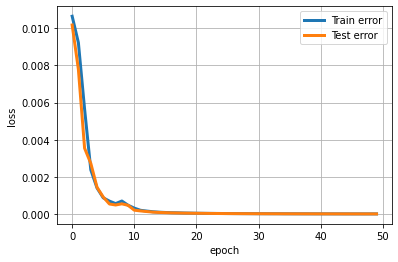

In [8]:
plt.plot(range(50),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(50),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_356765/2300132830.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()


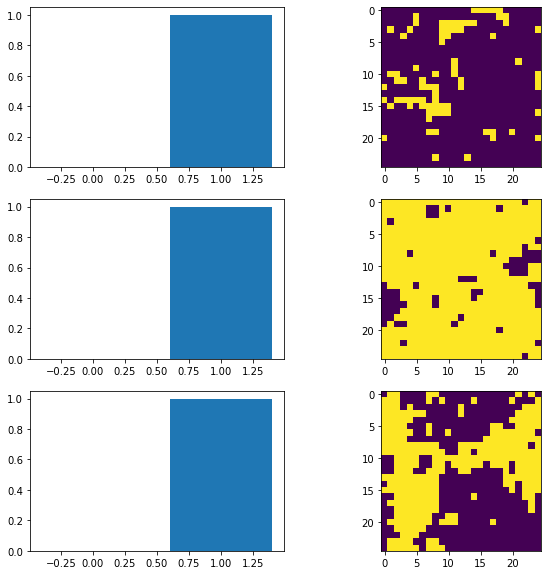

In [9]:
plt.figure(figsize=(10,10))
for index in [0,1,2]:
  
  image, label = trainingdata[index]
  # print(image)
  predicted_output = model(images)[index]
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()

  plt.subplot(3,2,2*(index)+1)
  plt.bar(list(range(len(prob_output))), prob_output)
 
  plt.subplot(3,2,2*(index)+2)
  plt.imshow(image.squeeze().numpy())
  
plt.show()

Now lets use the dataset that we classified by temperature to plot confidence vs temperature

/tmp/ipykernel_356765/1446560378.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()


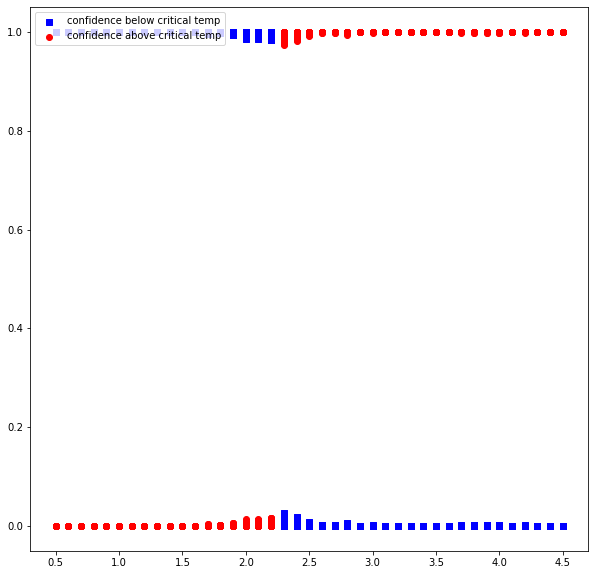

In [10]:
temp_pred_below = []
temp_pred_above = []
for idx in range(len(perfdata)):
  image, label = perfdata[idx]
  predicted_output = model(image.unsqueeze(0))
  
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()
  predicted_label = torch.argmax(predicted_output).item()
  # print(f"predicted label: {predicted_label}, actual label: {label}")

  #get temp from label
  temp = perfdata.classes[label]
  temp_pred_below.append([float(temp), prob_output[0][1]])
  temp_pred_above.append([float(temp), prob_output[0][0]])

#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter([x[0] for x in temp_pred_below], [x[1] for x in temp_pred_below], c='b', marker="s", label='confidence below critical temp')
ax.scatter([x[0] for x in temp_pred_above], [x[1] for x in temp_pred_above], c='r', marker="o", label='confidence above critical temp')

plt.legend(loc='upper left');
plt.show()




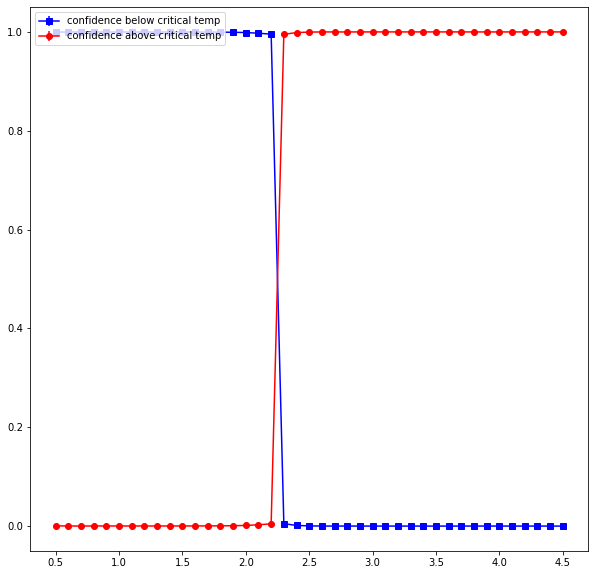

In [11]:
#plot the average confidence for each temperature with error bars
#error bars are standard deviation devide by sqrt of number of samples

# get the average & standard deviation of confidence for each temperature
temp_pred_below_avg = {}
temp_pred_above_avg = {}

temp_pred_below_std = {}
temp_pred_above_std = {}

for temp, pred in temp_pred_below:
    if temp in temp_pred_below_avg:
        temp_pred_below_avg[temp].append(pred)
    else:
        temp_pred_below_avg[temp] = [pred]

    if temp in temp_pred_below_std:
        temp_pred_below_std[temp].append(pred)
    else:
        temp_pred_below_std[temp] = [pred]

for temp, pred in temp_pred_above:
    if temp in temp_pred_above_avg:
        temp_pred_above_avg[temp].append(pred)
    else:
        temp_pred_above_avg[temp] = [pred]

    if temp in temp_pred_above_std:
        temp_pred_above_std[temp].append(pred)
    else:
        temp_pred_above_std[temp] = [pred]

temp_pred_above_avg = {temp: np.mean(pred) for temp, pred in temp_pred_above_avg.items()}
temp_pred_below_avg = {temp: np.mean(pred) for temp, pred in temp_pred_below_avg.items()}

temp_pred_above_err = {temp: np.std(pred)/np.sqrt(len(pred)) for temp, pred in temp_pred_above_std.items()}
temp_pred_below_err = {temp: np.std(pred)/np.sqrt(len(pred)) for temp, pred in temp_pred_below_std.items()}

    
#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(list(temp_pred_below_avg.keys()), list(temp_pred_below_avg.values()), yerr=list(temp_pred_below_err.values()), c='b', marker="s", label='confidence below critical temp')
ax.errorbar(list(temp_pred_above_avg.keys()), list(temp_pred_above_avg.values()), yerr=list(temp_pred_above_err.values()), c='r', marker="o", label='confidence above critical temp')

plt.legend(loc='upper left');
plt.show()
    


# Save the model

In [13]:
# save the model
torch.save(model.state_dict(), './models/Basic_NN.pth')